<a href="https://colab.research.google.com/github/MeysamEffati/Image-Segmentation-With-U-Net/blob/main/UNet-ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [205]:
import tensorflow as tf

In [206]:
import tensorflow_datasets as tfds
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-dozm480x
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-dozm480x
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301582 sha256=be83b23e4cddc292d88e6d8b09e7cc1bf4fa5200451eff26092ee5480b51b1f3
  Stored in directory: /tmp/pip-ephem-wheel-cache-lwmxi_lb/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [207]:
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt

In [ ]:
tfds.list_builders()

In [209]:
trainds, testds = tfds.load('oxford_iiit_pet', split = ['train[:80%]', 'train[80%:]'])
print('trainds',len(trainds),'testds', len(testds))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMZZLMF/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteMZZLMF/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
trainds 2944 testds 736


In [210]:
class Augment(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    # self.Augment_image = tf.keras.layers.RandomFlip('horizontal', seed = 42)
    self.Augment_image = tf.keras.layers.RandomBrightness(factor=0.02, seed = 42)
    # self.probabiltyofflip = 0.5
    # self.seed = 42

  def call(self, element):
    # if tf.random.uniform([], seed=self.seed) > self.probabiltyofflip:


    element['image'] = self.Augment_image(element['image'])/255
    element['segmentation_mask'] = self.Augment_image(element['segmentation_mask'])/255
    # element['image'] = tf.image.flip_left_right(element['image']/255)
    # element['segmentation_mask'] = tf.image.flip_left_right(element['segmentation_mask']/255)
    return element


In [ ]:
? tf.random.uniform

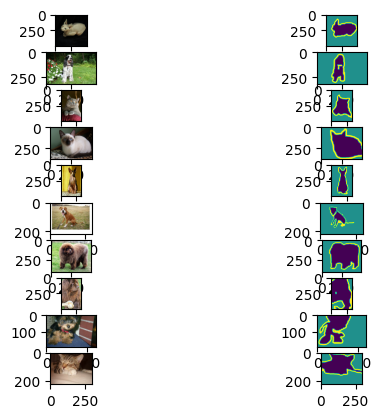

In [211]:
fig, ax  = plt.subplots(10,2)
i = 0
for data in trainds.take(10):
  image_aug = data['image']
  Seg_aug = data['segmentation_mask']
  ax[i, 0].imshow(image_aug)
  ax[i, 1].imshow(Seg_aug)
  i += 1


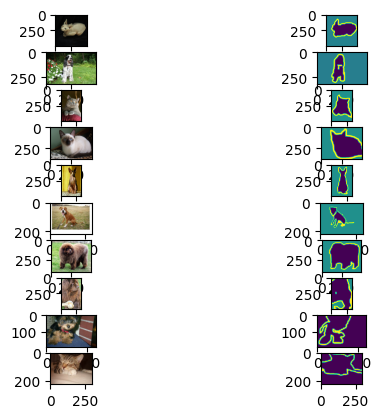

In [212]:
buffer_size = 10
batch_size = 1
epoch_size = 1
train_batch = (trainds
               .batch(batch_size)
               .map(Augment()))
fig, ax  = plt.subplots(10,2)
i = 0
for data in train_batch.take(10):
  image_aug = data['image']
  Seg_aug = data['segmentation_mask']
  ax[i, 0].imshow(image_aug[0])
  ax[i, 1].imshow(Seg_aug[0])
  i += 1


# image_aug

<tf.Tensor: shape=(225, 300, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], dtype=float32)>

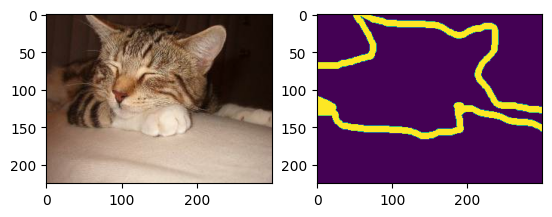

In [213]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(image_aug[0])
ax[1].imshow(Seg_aug[0])
Seg_aug[0]


In [216]:
import tensorflow
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, InputLayer, Input, UpSampling2D
from tensorflow.keras.models import Model

In [214]:
def Downsampling(Input, N_filters):
  layer = Conv2D(N_filters, kernel_size = (3, 3), activation = 'relu')(Input)
  layer = Conv2D(N_filters, kernel_size = (3, 3), activation = 'relu')(layer)
  maxpoolxy = MaxPooling2D(pool_size = (2, 2), strides = (2, 2))(layer)
  return maxpoolxy, layer

def Bottleneck(Input, N_filters):
  layer = Conv2D(N_filters, kernel_size = (3, 3), activation = 'relu')(Input)
  layer = Conv2D(N_filters, kernel_size = (3, 3), activation = 'relu')(layer)
  upsampled_Bottleneck = UpSampling2D(size=(2, 2), interpolation='nearest')(layer)
  upsampled_Bottleneck_half_filter = Conv2D(N_filters/2, kernel_size = (1, 1))(upsampled_Bottleneck)
  return upsampled_Bottleneck_half_filter, layer


def Upsampling(In_Enc, In_Bott_Dec, Num_Filters):
  s1, x_E, y_E, f = In_Enc.shape
  s1, x_BD, y_BD, f = In_Bott_Dec.shape
  start_ind_x = ( x_E- x_BD)/2
  end_ind_x = x_E - start_ind_x
  start_ind_y = ( y_E - y_BD)/2
  end_ind_y = y_E - start_ind_y
  In_Enc = In_Enc[:, int(start_ind_x):int(end_ind_x), int(start_ind_y):int(end_ind_y), :]
  Concatenated_layer = Concatenate()([In_Enc, In_Bott_Dec])
  Layer = Conv2D(Num_Filters, kernel_size = (3, 3), activation = 'relu')(Concatenated_layer)
  Layer = Conv2D(Num_Filters, kernel_size = (3, 3), activation = 'relu')(Layer)
  Upsampled_layer = UpSampling2D(size=(2,2), interpolation='nearest')(Layer)
  Upsampled_layer_half_filter = Conv2D(Num_Filters/2, kernel_size = (1, 1))(Upsampled_layer)
  return Upsampled_layer_half_filter, Layer

def OutCell(In_Enc, In_Bott_Dec, Num_Filters):
  s1, x_E, y_E, f = In_Enc.shape
  s1, x_BD, y_BD, f = In_Bott_Dec.shape
  start_ind_x = ( x_E- x_BD)/2
  end_ind_x = x_E - start_ind_x
  start_ind_y = ( y_E - y_BD)/2
  end_ind_y = y_E - start_ind_y
  In_Enc = In_Enc[:, int(start_ind_x):int(end_ind_x), int(start_ind_y):int(end_ind_y), :]
  Concatenated_layer = Concatenate()([In_Enc, In_Bott_Dec])
  Layer = Conv2D(Num_Filters, kernel_size = (3, 3), activation = 'relu')(Concatenated_layer)
  Layer = Conv2D(Num_Filters, kernel_size = (3, 3), activation = 'relu')(Layer)
  Layer = Conv2D(2, kernel_size = (1, 1), activation = 'relu')(Layer)
  return Layer




In [91]:
from tensorflow.keras.layers import Concatenate

In [217]:
Input_Layer = Input(shape = (572, 572, 1))
Downsampling1,lastlayer1 = Downsampling(Input_Layer, 64)
Downsampling2, lastlayer2 = Downsampling(Downsampling1, 128)
Downsampling3, lastlayer3 = Downsampling(Downsampling2, 256)
Downsampling4, lastlayer4 = Downsampling(Downsampling3, 512)
BottleNeck, layer_Bottleneck = Bottleneck(Downsampling4, 1024)


Upsampled, lastlayer= Upsampling(lastlayer4, BottleNeck, 512)
Upsampled, lastlayer = Upsampling(lastlayer3, Upsampled, 256)
Upsampled, lastlayer = Upsampling(lastlayer2, Upsampled, 128)
OutLayer = OutCell(lastlayer1, Upsampled, 64)
model = Model(Input_Layer, OutLayer)
model.summary()



Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_116 (InputLayer)      [(None, 572, 572, 1)]        0         []                            
                                                                                                  
 conv2d_1343 (Conv2D)        (None, 570, 570, 64)         640       ['input_116[0][0]']           
                                                                                                  
 conv2d_1344 (Conv2D)        (None, 568, 568, 64)         36928     ['conv2d_1343[0][0]']         
                                                                                                  
 max_pooling2d_450 (MaxPool  (None, 284, 284, 64)         0         ['conv2d_1344[0][0]']         
 ing2D)                                                                                     

In [218]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=[tf.keras.metrics.categorical_accuracy])

In [219]:
model.fit(train_batch)

ValueError: ignored